# IoT Streaming Analytics Demo
This is a demo notebook for Db2 Warehouse's integrated Apache Spark environment and how it can be used to process and land streaming data in Db2 tables. It runs through livy with a Spark kernel.

This notebook also uses ibmdbpy. If you are new to ibmdbpy, please refer to this [folder](https://github.com/ibmdbanalytics/ibmdbpy).

![](https://ibm.box.com/shared/static/6dr6gou6xr1alfwnj6zkj0tbsyc64vda.png)

## Set up IoT demo data producer
This demo relies on a little data producer container that you have to set up in addition to your dashDB local and Jupyter notebook containers on the same host machine. You can find it [here](https://github.com/ibmdbanalytics/dashdb_analytic_tools/tree/notebook-dev/dashdblocal_notebooks/iot_producer) in a sub folder of the dashDB Jupyter notebook container project. Please follow the instructions found there and perform the few simple steps to set it up. 

This producer will set up a Kafka server on port `9092` with a Kafka topic named `iot4dashdb` and permanently flow in there messages about wind turbine device measurements.

## Streaming environment setup for Spark

In [1]:
//%AddDeps org.apache.spark spark-streaming-kafka-0-10-assembly_2.11 2.0.2 before
// We use org.apache.spark spark-streaming-kafka-0-8-assembly_2.11 2.3.0 here --> still the same error
true // to avoid a syntax error because of an empty code cell

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
217,None,spark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res3: Boolean = true


__Imports__

In [2]:
import org.apache.kafka.clients.consumer.ConsumerRecord
import org.apache.kafka.common.serialization.StringDeserializer
import org.apache.spark.annotation.DeveloperApi
import org.apache.spark.sql.SQLContext
import org.apache.spark.sql.SparkSession
import org.apache.spark.sql.types.LongType
import org.apache.spark.sql.types.StringType
import org.apache.spark.sql.types.StructType
import org.apache.spark.sql.types.TimestampType
import org.apache.spark.streaming.Durations
import org.apache.spark.streaming.StreamingContext
import org.apache.spark.streaming.dstream.DStream
import org.apache.spark.streaming.kafka010.ConsumerStrategies
import org.apache.spark.streaming.kafka010.KafkaUtils
import org.apache.spark.streaming.kafka010.LocationStrategies
import org.apache.spark.sql.SaveMode

// import $ notation for Spark SQL
val sparkImplicits = spark.implicits
import sparkImplicits._

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<console>:35: error: object kafka010 is not a member of package org.apache.spark.streaming
       import org.apache.spark.streaming.kafka010.ConsumerStrategies
                                         ^



Local visualisations will use pandas and matplotlib.

In [3]:
%local

%matplotlib inline

#Useful imports for local visualisations
import pandas as pd
import matplotlib.pyplot as plt

__Kafka assembly__

To prepare the Spark runtime for kafka streaming inside dashDB, we need to download the kafka assembly explicitly and place it in the spark/defaultlibs directory for the current user. This is done in the following cell. When you do this for the first time in your user's envuironment, you need to restart the kernel in order to make it effective in the classpath. You can do this by selecting `File->Close and Halt` and then opening this notebook again.

Attention: Any .jar in $HOME/spark/defaultlibs will be placed into the classpath for **all** Spark apps submitted
by the user. With large assemblies like kafka, which contain widely used packages, e.g. jackson or apache commons, 
this may override classes that your applciation expects, so be careful.

Let's check if you have Kafka assembly available:

In [2]:
val path = "/mnt/blumeta0/home/bluadmin/spark/defaultlibs"
val kafka_assembly = "spark-streaming-kafka-0-8-assembly_2.11-2.3.0.jar"
val url = "http://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-8-assembly_2.11/2.3.0/" + kafka_assembly
if (new java.io.File(path + "/" + kafka_assembly).exists()) {
    print("kafka assembly found")
} else {
    import scala.sys.process._pzd
    s"wget -nv -P $path $url"! ;
    print("loaded kafka assembly, please restart the notebook")
}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<console>:33: error: object _pzd is not a member of package scala.sys.process
           import scala.sys.process._pzd
                  ^
<console>:34: error: value ! is not a member of String
           s"wget -nv -P $path $url"! ;
                                    ^



__Kafka configuration to connect to our IoT demo data producer__

Now we define a utility function to set up a Kafka Streaming context, and run it for an optionally defined period of timeoutMillisecs with a given processing function. 

**Important note** : When we run this interactively in a notebook cell, it's important to set the timeout to a specific value in order to stop the streaming context. Otherwise it will keep running and produce cell output, even after the cell has finished executing.

Note also that a streaming context cannot be re-used after it has executed, so we can't keep it across cells and therefore we have to use the utility function to re-create it before every execution.

We use a `finally` block to make sure the context is stopped even in case of exception; otherwise the whole streaming infrastructure becomes unusable within the notebook kernels lifetime.

In [5]:
val brokers = "localhost:9092"
val topics = "iot4dashdb"
val topicList = topics.split(",")

val kafkaParams = Map[String, Object] (
    "bootstrap.servers" -> brokers,
    "key.deserializer" -> classOf[StringDeserializer],
    "value.deserializer" -> classOf[StringDeserializer],
    "group.id" -> "democonsumer",
    "auto.offset.reset" -> "latest",
    "enable.auto.commit" -> (false: java.lang.Boolean)
)

type inputStream = DStream[ConsumerRecord[String,String]]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

brokers: String = localhost:9092
topics: String = iot4dashdb
topicList: Array[String] = Array(iot4dashdb)
kafkaParams: scala.collection.immutable.Map[String,Object] = Map(key.deserializer -> class org.apache.kafka.common.serialization.StringDeserializer, auto.offset.reset -> latest, group.id -> democonsumer, bootstrap.servers -> localhost:9092, enable.auto.commit -> false, value.deserializer -> class org.apache.kafka.common.serialization.StringDeserializer)
defined type alias inputStream


In [6]:
var timeoutMillisecs: Option[Long] = None

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

timeoutMillisecs: Option[Long] = None


In [7]:
def runStreamingContext(processMessages: inputStream => Unit): Unit = {
    val ssc = new StreamingContext(spark.sparkContext, Durations.seconds(3))
    val messages = KafkaUtils.createDirectStream(
                ssc,
                LocationStrategies.PreferConsistent,
                ConsumerStrategies.Subscribe[String,String](topicList, kafkaParams)
            );
    processMessages(messages)
    
    try {
        ssc.start()
        timeoutMillisecs match {
            case Some(t) => ssc.awaitTerminationOrTimeout(t)
            case _ => ssc.awaitTermination()
        }
    } finally {
        ssc.stop(false, true)
    }
}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<console>:45: error: not found: value KafkaUtils
           val messages = KafkaUtils.createDirectStream(
                          ^
<console>:47: error: not found: value LocationStrategies
                       LocationStrategies.PreferConsistent,
                       ^
<console>:48: error: not found: value ConsumerStrategies
                       ConsumerStrategies.Subscribe[String,String](topicList, kafkaParams)
                       ^



When running interactively in the notebook we want all streaming tests to run only for 10 seconds and stop automatically. Later, when we deploy the notebook as a stand-alone Spark application, we want the processing to continue until the application is stopped externally. Hence we tag the cell NOT-FOR-APP.

In [8]:
timeoutMillisecs = Some(10000)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

timeoutMillisecs: Option[Long] = Some(10000)


## Data exploration

First, we simply iterate over the batch RDDs and print out their content, just to explore the data in our Kafka queue. We also don't need this when we deploy the notebook as application. So we tag the cell accordingly.

**Important note**: Before you execute the cell below, you will need to start the producer container that writes into the kafka queue. When the IoT producer container is not started or has already terminated, the streaming computation in the following cell will hang and never return.

Please refer to [this document](https://github.com/ibmdbanalytics/dashdb_analytic_tools/blob/livy-demos/dashdblocal_notebooks/iot_producer/README.md) to start the producer container.

In [9]:
runStreamingContext(messages =>
  // The ConsumerRecord objects produced by a Kafa queue are not serializable, need to map them to a String
  // before collecting
  messages.map(record => s"${record.key} -> ${record.value}").
    foreachRDD(rdd => rdd.collect().foreach(println))
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<console>:36: error: not found: value runStreamingContext
       runStreamingContext(messages =>
       ^



So this gives us an idea about the JSON format we can expect from our data source. Lets try to parse each batch into a DataSet with Spark SQL. We don't want Spark to perform automatic JSON schema detection over and over again for each batch, so we give it a pre-defined schema

In [10]:
val schema = (new StructType).
    add("payload", (new StructType).
        add("temperature", LongType).
        add("tempOutside", LongType).
        add("powerProd", LongType).
        add("noiseLevel1", LongType).
        add("time", TimestampType)).
    add("deviceId", StringType).
    add("deviceType", StringType).
    add("eventType", StringType)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

schema: org.apache.spark.sql.types.StructType = StructType(StructField(payload,StructType(StructField(temperature,LongType,true), StructField(tempOutside,LongType,true), StructField(powerProd,LongType,true), StructField(noiseLevel1,LongType,true), StructField(time,TimestampType,true)),true), StructField(deviceId,StringType,true), StructField(deviceType,StringType,true), StructField(eventType,StringType,true))


As we can see, the produced data has a nested structure. 
Spark can deal with this type of schema, but it's not suitable being stored in a plain SQL database table, so we flatten it to straight rows.

In [11]:
def processStream1(messages: inputStream): Unit = {
    messages.map(_.value).foreachRDD(rdd => {
        val ds = spark.read.schema(schema).json(rdd)
        val flatDataset = ds.select($"payload.temperature", $"payload.tempOutside",
            $"payload.powerProd", $"payload.noiseLevel1", $"payload.time",
            $"deviceId", $"deviceType", $"eventType")
        flatDataset.select("deviceId", "time", "temperature", "tempOutside", "powerProd", "noiseLevel1").show(false)
    })
}
runStreamingContext(processStream1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<console>:38: error: not found: value runStreamingContext
       runStreamingContext(processStream1)
       ^
<console>:38: error: missing argument list for method processStream1
Unapplied methods are only converted to functions when a function type is expected.
You can make this conversion explicit by writing `processStream1 _` or `processStream1(_)` instead of `processStream1`.
       runStreamingContext(processStream1)
                           ^



## Write IoT records to a persistent table

In the desired deployed application we want to write the records read from the queue into a Db2 table instead of only printing them out the datasets. In this demonstration here we will always first empty the table in the first batch after the application is started. We use Spark's *'Overwrite'* mode for writing the first batch to clear a pre-existing table and then use *'Append'* mode in subsequent batches.

You can check in your Db2 Warehouse console that a table called USERDATA.IOT_EVENTS has been created. For example, run the following SQL query to see how many records have been written: 
> SELECT COUNT(*) FROM USERDATA.IOT_EVENTS.

You will notice that there are only a few rows compared to the number of generated records. For example, with a timeout set to 10s, you will collect approximately 8 rows. With a timeout of 50s, there will be approximetely 30 etc.

In [12]:
val tableName = "USERDATA.IOT_EVENTS"

var saveMode = SaveMode.Overwrite
def processStream2(messages: inputStream): Unit = {
    messages.map(_.value).foreachRDD(rdd => {
        val ds = spark.read.schema(schema).json(rdd)
        val flatDataset = ds.select($"payload.temperature", $"payload.tempOutside",
            $"payload.powerProd", $"payload.noiseLevel1", $"payload.time",
            $"deviceId", $"deviceType", $"eventType")
        flatDataset.write.format("com.ibm.idax.spark.idaxsource").
            option("dbtable", tableName).
            option("allowAppend", "TRUE").
            mode(saveMode).
            save()
        println("Batch written to database")
        saveMode = SaveMode.Append
    })
}
runStreamingContext(processStream2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<console>:36: error: not found: value SaveMode
       var saveMode = SaveMode.Overwrite
                      ^



In case you want to capture some longer timeframes of events in this notebook, increase the timeoutMillisecs e.g. by running the cell below and then running the previous cell again.

In [13]:
timeoutMillisecs = Some(120000)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

timeoutMillisecs: Option[Long] = Some(120000)


## Deploying automatic background IoT landing app inside dashDB

Finally you can deploy the essential parts of this notebook (i.e. by excluding unnecessary cells with a`//NOT-FOR-APP` comment) as a stand-alone scala application into dashDB. To do this, select `File -> Deploy as -> Deploy to dashDB Spark` from the menu (may not be available, however). Then use one of the alternatives shown in the result page to launch the application, e.g. using the [SPARK_SUBMIT](https://www.ibm.com/support/knowledgecenter/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/r_spark_applications_spark_submit.html) stored procedure. 

If you want to take a look at the generated code, select `File -> Download as -> Scala class (in browser)`

This notebook is set up so that the timeout does not apply in the exported application, so your streaming context will continue to run and insert events into the database until the application is explicitly stopped via [spark-submit.sh --kill](https://www.ibm.com/support/knowledgecenter/SS6NHC/com.ibm.swg.im.dashdb.doc/learn_how/spark_ref.html), the 
[CANCEL_APP](https://www.ibm.com/support/knowledgecenter/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/r_spark_applications_cancel_app.html) stored procedure, the [/public/apps/cancel](https://developer.ibm.com/clouddataservices/wp-content/themes/projectnext-clouddata/dashDBanalytics/#/) endpoint of dashDB's REST API or the Spark monitoring UI in the dashDB console (`Monitor->Workloads->Spark`).

**For your convenience** you can simply use the cells in the next section to start and stop the deployed app in the background.

## Launching deployed IoD landing app in background
Run the following cell to launch the just deployed IoD landing app inside dashDB. The cell keeps a database connection open that we will use to stop the landing app again when you execute the subsequent cell.

In [14]:
import java.sql.DriverManager
import java.sql.Connection
import java.sql.SQLException
val connection = DriverManager.getConnection("jdbc:db2:BLUDB")
var iot_lander_submission_id : String = null
try {   
    val sp_call = connection.prepareCall(
      "CALL IDAX.SPARK_SUBMIT(?, '{ \"appResource\" : \"IoT_demo-assembly-1.0.jar\", " +
                                    "\"mainClass\" : \"SampleApp\"}', " +
                                    "'mode=async')")
    sp_call.registerOutParameter(1, java.sql.Types.VARCHAR);
    sp_call.executeUpdate();
    iot_lander_submission_id = sp_call.getString(1)
    println("Successfully launched IoT landing app with submission id " + iot_lander_submission_id);
} catch {
    case e: SQLException => { println("Error: " + e) }
    iot_lander_submission_id = null
}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import java.sql.DriverManager
import java.sql.Connection
import java.sql.SQLException
connection: java.sql.Connection = com.ibm.db2.jcc.uw.UWConnection@1be9082b
iot_lander_submission_id: String = null
Error: com.ibm.db2.jcc.am.SqlException: DB2 SQL Error: SQLCODE=-438, SQLSTATE=38A00, SQLERRMC=CDFAA0802E Spark application error: Attempt to submit the application , DRIVER=4.26.14


You can use the cells in the subsequent section to observe the progress of landing IoT messages in the target table. When you are done, you can run the following cell to stop the IoT landing app that you started in the background in the previous cell.

In [15]:
if(iot_lander_submission_id !=null) {
    try {   
        val sp_call = connection.prepareCall("CALL IDAX.CANCEL_APP(?)")
        sp_call.setString(1, iot_lander_submission_id);
        sp_call.executeUpdate();
        println("Successfully stopped IoT landing app with submission id " + iot_lander_submission_id)
    } catch {
        case e: SQLException => { println("Error: " + e) }
    }
} else println("No submission ID defined")
connection.close()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No submission ID defined


## Check landed IoT data
You can verify the landed data in Db2 Warehouse. For this we simply establish a data frame on the result table.

In [16]:
var landed_iot_data = spark.read.
   format("com.ibm.idax.spark.idaxsource").
   option("url", "jdbc:db2:BLUDB").
   option("dbtable", tableName).
   load()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

landed_iot_data: org.apache.spark.sql.DataFrame = [temperature: bigint, tempOutside: bigint ... 6 more fields]


Now we show the content. You can verify the progress of your deployed landing app by running the next cell repeatetly and check the new records and overall count.

In [17]:
println("Total IoT records: "+ landed_iot_data.count())
println("Newest 10 IoT records:")
landed_iot_data.select("deviceId", "time", "temperature", "tempOutside", "powerProd", "noiseLevel1").
                orderBy(org.apache.spark.sql.functions.col("time").desc).show(10, false)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total IoT records: 60
Newest 10 IoT records:
+--------+-------------------+-----------+-----------+---------+-----------+
|deviceId|time               |temperature|tempOutside|powerProd|noiseLevel1|
+--------+-------------------+-----------+-----------+---------+-----------+
|2700    |2019-10-28 09:37:33|30         |18         |1836     |82         |
|2700    |2019-10-28 09:37:31|35         |18         |1832     |82         |
|2705    |2019-10-28 09:37:30|37         |18         |1830     |82         |
|2706    |2019-10-28 09:37:28|31         |18         |1830     |82         |
|2707    |2019-10-28 09:37:26|37         |18         |1828     |82         |
|2704    |2019-10-28 09:37:24|32         |18         |1830     |82         |
|2700    |2019-10-28 09:37:23|33         |18         |1832     |82         |
|2700    |2019-10-28 09:37:21|31         |18         |1829     |82         |
|2700    |2019-10-28 09:37:19|30         |18         |1827     |82         |
|2706    |2019-10-28 09:37:17|3

## Visualisation of time series

You could want to visualize the data you are collecting. Let's plot some of the features over time.

__Note : Make a bridge between remote and local__

So far we've been using Spark servers and the data is accessed remotely. If we plot visualisations now, they won't appear right on your screen : you will have to fetch them, using their adress, to open them locally. So for convenience, visualisations will be made locally thanks to the __%local__ magic. Therefore, we need to create a temporary view of the data, and query it with the %%sql magic in order to access it locally and plot it directly. Note that the data on the Spark cluster is a Spark dataframe, whereas the data we handle locally is a pandas dataframe.

In the following cells, we will:
1. Create a SQL temporary view of the tornado (Spark) dataframe
2. Run a %%sql cell magic to query the data, and output it to the local space. The table is now seen as a Pandas dataframe.
3. We use this Pandas dataframe to make our graphs, which we output locally.

In [18]:
landed_iot_data.createOrReplaceTempView("turbine")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
%%sql -o turbine --maxrows -1
SELECT * FROM turbine

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

In [20]:
%local
turbine['time']=pd.to_datetime(turbine['time'])

As you may have noticed, our data comes from several devices. Let's focus on only one device to start with. You can change the deviceId if you like.

In [21]:
%local
print(turbine['deviceId'].unique())
device=turbine[turbine['deviceId']==2706]

[2709 2707 2701 2702 2703 2705 2708 2700 2706 2704]


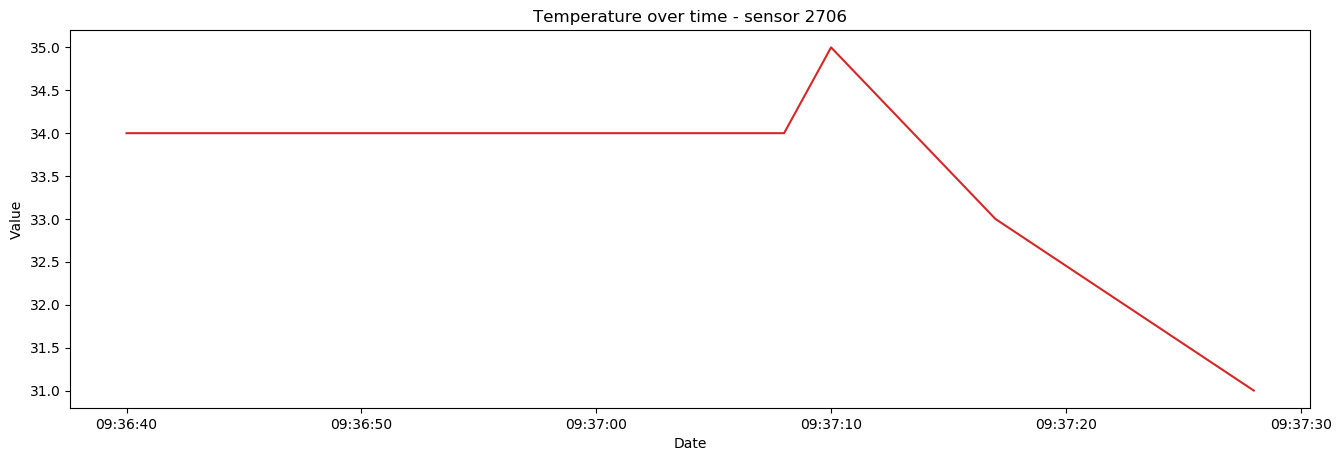

In [22]:
%local

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Basic plot
def plot_df(dataFrame, x1, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x1, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(device, x1=device.time, y=device.temperature, title='Temperature over time - sensor 2706')    

It could be useful to compare the temperature measured by the sensor with the power production over time. Is the temperature raising over time? Does an increase in power production implies an increase in temperature? With some lag?

Note that the data generator we used here doesn't provide very meaningful data regarding Physics... Furthermore, we would need a far longer observation time to make any conclusion. However, the following visualisations are provided for the sake of our use case.

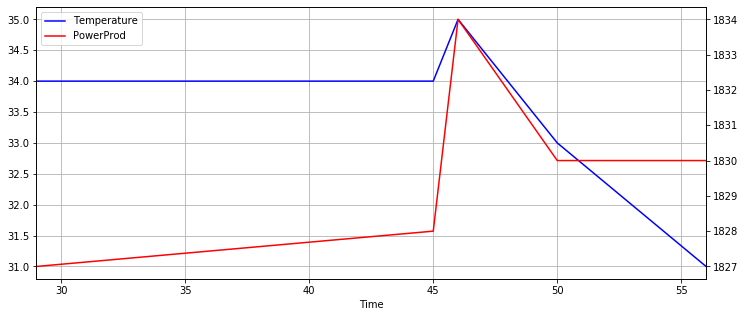

In [23]:
%local

# Temperature and power production over time in a particular sensor

plt.figure(figsize=(12,5))
plt.xlabel('Time')

ax1 = device.temperature.plot(color='blue', grid=True, label='Temperature')
ax2 = device.powerProd.plot(color='red', grid=True, secondary_y=True, label='PowerProd')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()